In [8]:
# Import necessary libraries
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Importing the Training Data file
df = pd.read_csv('training_data_lowercase.csv', sep='\t', names=['tag', 'text'])

#Defining target and features
X = df['text']
y = df['tag']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
### Initialize resources and define Functions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to get the correct WordNet POS tag
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,  # Adjectives
                "N": wordnet.NOUN,  # Nouns
                "V": wordnet.VERB,  # Verbs
                "R": wordnet.ADV}   # Adverbs
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if POS not found

# Function to lemmatize tokens with POS tags
def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

# Function for flexible preprocessing
def preprocess_text(text, clean=True, tokenize=True, lemmatize=True, remove_stopwords=True):
    # Step 1: Basic Cleaning (lowercasing and removing non-alphabetic characters)
    if clean:
        text = ' '.join([word.lower() for word in word_tokenize(text) if word.isalpha()])  # Join words with spaces

    # Step 2: Tokenization
    if tokenize:
        text = word_tokenize(text)
    else:
        text = text.split()  # Split into words even if not tokenizing with NLTK

    # Step 3: Stopword Removal
    if remove_stopwords:
        text = [word for word in text if word not in stop_words]

    # Step 4: Lemmatization with POS tagging
    if lemmatize:
        text = lemmatize_text(text)

    # Return processed text
    return text

In [11]:
# Preprocess training and test sets
X_train_clean = X_train.apply(
    lambda x: preprocess_text(x,
        clean=True,
        tokenize=True,
        lemmatize=True,
        remove_stopwords=False))
X_test_clean = X_test.apply(
    lambda x: preprocess_text(x,
        clean=True,
        tokenize=True,
        lemmatize=True,
        remove_stopwords=False))

In [12]:
# Join the tokens back into strings for vectorization
X_train_final = X_train_clean.apply(lambda tokens: " ".join(tokens))
X_test_final = X_test_clean.apply(lambda tokens: " ".join(tokens))

In [13]:
### VECTORIZATION
# Vectorization using Bag of Words
do_bow = False
if do_bow:
    bow_vect = CountVectorizer(max_features=1000)

    # Fit and transform the training data, transform the test data
    X_train_vect = bow_vect.fit_transform(X_train_final).toarray()
    X_test_vect = bow_vect.transform(X_test_final).toarray()

# TF-IDF Vectorization
do_tf_idf = True
if do_tf_idf:
    tfidf_vect = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

    # Fit and transform the training data, transform the test data
    X_train_tfidf = tfidf_vect.fit_transform(X_train_final).toarray()
    X_test_tfidf = tfidf_vect.transform(X_test_final).toarray()

In [14]:
### TRAINING AND PREDICTING WITH DIFFERENT MODELS (bag of words)
do_bow_training = False
if do_bow_training:
    # Logistic Regression
    lr_model_bow = LogisticRegression(max_iter=1000).fit(X_train_vect, y_train)
    y_pred_lr_bow = lr_model_bow.predict(X_test_vect)

    # Support Vector Machine (SVM)
    svm_model_bow = SVC(kernel='linear', random_state=42).fit(X_train_vect, y_train)
    y_pred_svm_bow = svm_model_bow.predict(X_test_vect)

    # Naive Bayes classifier
    nb_model_bow = MultinomialNB().fit(X_train_vect, y_train)
    y_pred_nb_bow = nb_model_bow.predict(X_test_vect)

    # XGB Classifier
    xgb_model_bow = XGBClassifier(random_state=42).fit(list(X_train_vect), y_train)
    y_pred_xgb_bow = xgb_model_bow.predict(list(X_test_vect))

In [15]:
### GRID SEARCH FOR BEST HYPERPARAMETERS
# We didn't have time to implement the best hyperparameters in the final model. But we wanted to leave the code here.
do_grid_search = False
if do_grid_search:
    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': [1e-2, 0.1, 1],
        'kernel': ['rbf', 'linear'],
        'class_weight': [None, 'balanced']}

    # Initialize the SVC model
    svc = SVC()
    # Perform grid search
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_tfidf, y_train)

    # Get the best parameters
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)

In [16]:
# TODO: Explain we wanted more beautiful functions.

In [17]:
### TRAINING AND PREDICTING WITH DIFFERENT MODELS (TF-IDF)
do_tfidf_training = True
if do_tfidf_training:
    # Support Vector Machine (SVM)
    svm_model_tfidf = SVC(kernel='linear', random_state=42).fit(X_train_tfidf, y_train)
    y_pred_svm_tfidf = svm_model_tfidf.predict(X_test_tfidf)
    
    """ # Logistic Regression
    lr_model_tfidf = LogisticRegression(max_iter=100).fit(X_train_tfidf, y_train)
    y_pred_lr_tfidf = lr_model_tfidf.predict(X_test_tfidf)

    # Naive Bayes classifier
    nb_model_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)
    y_pred_nb_tfidf = nb_model_tfidf.predict(X_test_tfidf)

    # XGB Classifier
    xgb_model_tfidf = XGBClassifier(random_state=42).fit(list(X_train_tfidf), y_train)
    y_pred_xgb_tfidf = xgb_model_tfidf.predict(list(X_test_tfidf)) """

In [18]:
# Optional: Save models for future use
""" import pickle
with open('svm_model_w2v.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

with open('logreg_model_w2v.pkl', 'wb') as f:
    pickle.dump(logreg_model, f)

with open('rf_model_w2v.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('xgb_model_w2v.pkl', 'wb') as f:
    pickle.dump(xgb_model, f) """

" import pickle\nwith open('svm_model_w2v.pkl', 'wb') as f:\n    pickle.dump(svm_model, f)\n\nwith open('logreg_model_w2v.pkl', 'wb') as f:\n    pickle.dump(logreg_model, f)\n\nwith open('rf_model_w2v.pkl', 'wb') as f:\n    pickle.dump(rf_model, f)\n\nwith open('xgb_model_w2v.pkl', 'wb') as f:\n    pickle.dump(xgb_model, f) "

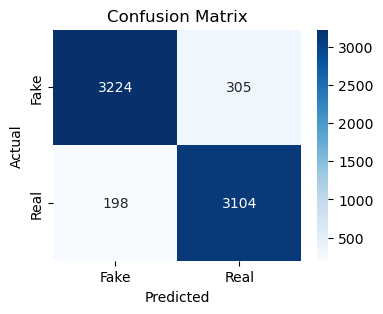

In [20]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm_tfidf)

# Visualize confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
### EVALUATION (Bag of Words)
do_bow_eval = False
if do_bow_eval:
    print("BAG OF WORDS (Clean, Tokenized, Lemmatized, No StopWords removal)")
    
    acc_score_svm = accuracy_score(y_test, y_pred_svm_bow)
    print(f"Accuracy Score SVM: {acc_score_svm:.4f}")
    report_svm = classification_report(y_test, y_pred_svm_bow)
    #print("Classification Report SVM:\n", report_svm)
    
    """ acc_score_lr = accuracy_score(y_test, y_pred_lr_bow)
    print(f"Accuracy Score Log Regression: {acc_score_lr:.4f}")
    report_lr = classification_report(y_test, y_pred_lr_bow)
    #print("Classification Report Log Regression:\n", report_lr)

    acc_score_nb = accuracy_score(y_test, y_pred_nb_bow)
    print(f"Accuracy Score Naive Bayes: {acc_score_nb:.4f}")
    report_nb = classification_report(y_test, y_pred_nb_bow)
    #print("Classification Report Naive Bayes:\n", report_nb)

    acc_score_xgb = accuracy_score(y_test, y_pred_xgb_bow)
    print(f"Accuracy Score XGB Classifier: {acc_score_xgb:.4f}")
    report_xgb = classification_report(y_test, y_pred_xgb_bow)
    #print("Classification Report XGB Classifier:\n", report_xgb) """

In [22]:
### EVALUATION (TF_IDF)
print("TF-IDF  (Clean, Tokenized, Lemmatized, No StopWords removal)")

acc_score_svm = accuracy_score(y_test, y_pred_svm_tfidf)
print(f"Accuracy Score SVM: {acc_score_svm:.4f}")
report_svm = classification_report(y_test, y_pred_svm_tfidf)
#print("Classification Report SVM:\n", report_svm)

""" acc_score_lr = accuracy_score(y_test, y_pred_lr_tfidf)
print(f"Accuracy Score Log Regression: {acc_score_lr:.4f}")
report_lr = classification_report(y_test, y_pred_lr_tfidf)
#print("Classification Report Log Regression:\n", report_lr)

acc_score_nb = accuracy_score(y_test, y_pred_nb_tfidf)
print(f"Accuracy Score Naive Bayes: {acc_score_nb:.4f}")
report_nb = classification_report(y_test, y_pred_nb_tfidf)
#print("Classification Report Naive Bayes:\n", report_nb)

acc_score_xgb = accuracy_score(y_test, y_pred_xgb_tfidf)
print(f"Accuracy Score XGB Classifier: {acc_score_xgb:.4f}")
report_xgb = classification_report(y_test, y_pred_xgb_tfidf)
#print("Classification Report XGB Classifier:\n", report_xgb) """

TF-IDF  (Clean, Tokenized, Lemmatized, No StopWords removal)
Accuracy Score SVM: 0.9264


' acc_score_lr = accuracy_score(y_test, y_pred_lr_tfidf)\nprint(f"Accuracy Score Log Regression: {acc_score_lr:.4f}")\nreport_lr = classification_report(y_test, y_pred_lr_tfidf)\n#print("Classification Report Log Regression:\n", report_lr)\n\nacc_score_nb = accuracy_score(y_test, y_pred_nb_tfidf)\nprint(f"Accuracy Score Naive Bayes: {acc_score_nb:.4f}")\nreport_nb = classification_report(y_test, y_pred_nb_tfidf)\n#print("Classification Report Naive Bayes:\n", report_nb)\n\nacc_score_xgb = accuracy_score(y_test, y_pred_xgb_tfidf)\nprint(f"Accuracy Score XGB Classifier: {acc_score_xgb:.4f}")\nreport_xgb = classification_report(y_test, y_pred_xgb_tfidf)\n#print("Classification Report XGB Classifier:\n", report_xgb) '

In [ ]:
### CROSS-VALIDATION
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation and compute accuracy for each fold
cv_scores = cross_val_score(svm_model_tfidf, X_train_tfidf, y_train, cv=kfold, scoring='accuracy')
# Print the average accuracy and standard deviation across folds
print(f"Cross-validated Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

<Figure size 1000x600 with 0 Axes>

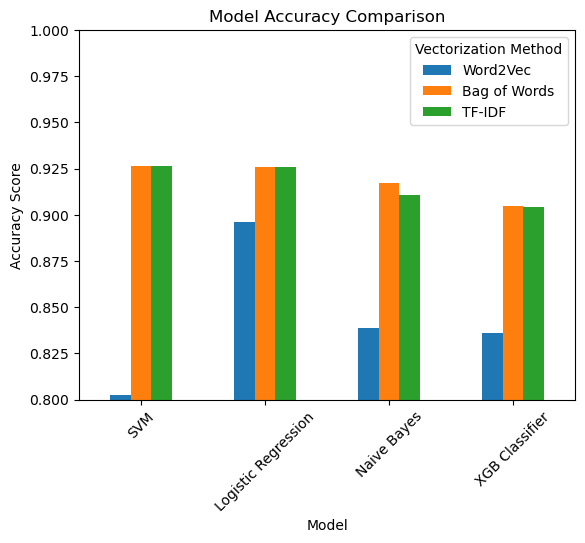

In [25]:
# Initialize a dictionary to hold the accuracy scores for each model and vectorization method
model_results = {
    'Word2Vec': {
        'SVM': 0.8026,
        'Logistic Regression': 0.8962,
        'Naive Bayes': 0.8390,
        'XGB Classifier': 0.8360},
    'Bag of Words': {
        'SVM': 0.9264,
        'Logistic Regression': 0.9259,
        'Naive Bayes': 0.9173,
        'XGB Classifier': 0.9046},
    'TF-IDF': {
        'SVM': 0.9264,
        'Logistic Regression': 0.9258,
        'Naive Bayes': 0.9107,
        'XGB Classifier': 0.9041}
}

# Convert dictionary into a pandas DataFrame
results_df = pd.DataFrame(model_results)

# Plot the results using seaborn
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', rot=0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Vectorization Method')
plt.ylim([0.8, 1.0])
plt.show()

In [29]:
# Preprocess validation set to make predictions with the final model
real_df = pd.read_csv('testing_data_lowercase_nolabels.csv', sep='\t', names=['text'])
X_val = real_df['text']
X_val_clean = X_val.apply(
    lambda x: preprocess_text(x,
        clean=True,
        tokenize=True,
        lemmatize=True,
        remove_stopwords=False))

X_val_final = X_val_clean.apply(lambda tokens: " ".join(tokens))

X_val_tfidf = tfidf_vect.transform(X_val_final).toarray()

y_pred_val = svm_model_tfidf.predict(X_val_tfidf)

In [33]:
# Creating the CSV file with the predictions to deliver
real_df['tag'] = y_pred_val
real_df.to_csv('G5.csv', index=False)